In [1]:
import os
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.io import loadmat

In [2]:
#Load 
onsets = loadmat("/Users/lovira/Desktop/402/402Folder/Main/Data/Stimuli/all_katerina_onsets.mat")['onsets']
path_to_text = "/Users/lovira/Desktop/402/402Folder/Main/Data/Stimuli"

story_files = [f for f in os.listdir(path_to_text) if f.endswith('csv')]

data_dir = "/Users/lovira/Desktop/402/402Folder/Main/Data/EEG"
eeg_file = [f for f in os.listdir(data_dir) if f.endswith('set')]

In [3]:
raw = mne.io.read_raw_eeglab(os.path.join(data_dir, eeg_file[7]), preload=True) 
raw = raw.set_eeg_reference() 
raw = raw.filter(1, 10, n_jobs=-1, verbose=False)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<ipython-input-3-dc6eabfb0885>:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(data_dir, eeg_file[7]), preload=True)


In [4]:
all_events = []
for k, story in enumerate(story_files):
    try:
        df = pd.read_csv(os.path.join(path_to_text, story))
    except:
        continue
    tags = [pos for w, pos in nltk.pos_tag(df.word)]
    df['POS'] = tags

    # Nouns
    samples_NN = raw.time_as_index(df.loc[df.POS =='NN', 'onset'].values + onsets[7, k]) 
    id_column_NN = np.ones_like(samples_NN)
    duration_column_NN = np.zeros_like(samples_NN)

    # Adjectives
    samples_JJ = raw.time_as_index(df.loc[df.POS == 'JJ', 'onset'].values + onsets [7, k])
    id_column_JJ = np.full_like(samples_JJ, 2)
    duration_column_JJ = np.zeros_like(samples_JJ)


    events_NN = np.array([samples_NN, duration_column_NN, id_column_NN])
    events_JJ= np.array([samples_JJ,duration_column_JJ, id_column_JJ])
    
    event_one_story = np.hstack((events_NN, events_JJ)).T
    all_events.append(event_one_story)
    


event_id = {'noun': 1, 'adjective': 2}
events = np.vstack(all_events)

1298 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


<ipython-input-5-df94f900521b>:2: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, event_id)


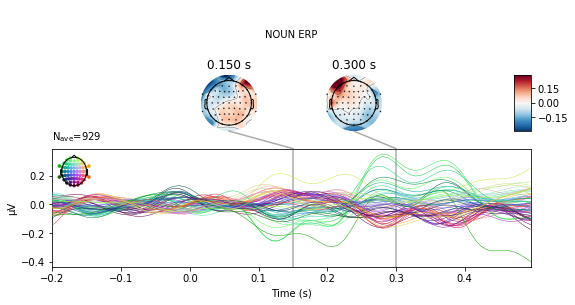

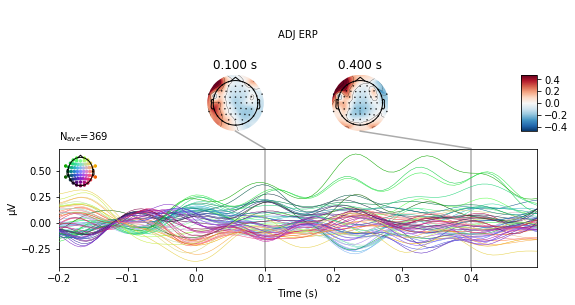

In [5]:
# Epochs and Averaging
epochs = mne.Epochs(raw, events, event_id)
evoked_nn = epochs['noun'].average()
evoked_adj = epochs['adjective'].average()
#Plots
evoked_nn.plot_joint(times=[0.15, 0.3], title='NOUN ERP'); 
evoked_adj.plot_joint(times=[0.1, 0.4], title='ADJ ERP');